In [2]:
# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.tree import plot_tree

from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

import seaborn as sns


In [3]:
# Import data
df = pd.read_csv("C:\\Users\\Teemu\\Desktop\\Housing_market_analysis\\Housing-market-analysis-with-webscraped-data\\REFINED-Jul-10-2022-house-market-data.csv", index_col=0)

df.rename(columns= {'Price (€)' : 'Price'}, inplace= True)

df

,Type,Address,District,City,Price,Area (sqm.),Year built,Form of ownership,Rooms
0,Kerrostalo,Soukanlahdenkatu 9,Armonkallio,Tampere,169000.0,28.0,1963,Omistusasunto,"1h, kk, kph."
1,Kerrostalo,Lepolankatu 3 A,Kivistönmäki,Lahti,39000.0,34.0,1972,Omistusasunto,1h + kk + alk + kh + p
2,Luhtitalo,Viljatullintie 4,Järvenperä,Espoo,139000.0,28.5,2018,Omistusasunto,1h + kk
3,Kerrostalo,Maariankatu 2,Keskusta,Turku,215000.0,48.0,1962,Omistusasunto,2h + avokeittiö + kph / wc + vh
4,Omakotitalo,Puunkaatajantie 23b,Heikinlaakso,Helsinki,215000.0,90.0,1933,Omistusasunto,"4h, k, aula, vh, th, s-tilat, wc, kuisti"
...,...,...,...,...,...,...,...,...,...
45946,Kerrostalo,Luhtikatu 3 F 18,Liipola,Lahti,79500.0,53.5,1972,Omistusasunto,2h + k + vh
45947,Omakotitalo,Tikkalantie 159,Tikkala,Tohmajärvi,278000.0,225.0,1926,Omistusasunto,"4mh, wc, kylpyhuone, keittiö, sali"
45949,Erillistalo,Kirjosillankatu,Myllypohja,Lahti,268000.0,245.0,1991,Omistusasunto,"5h + k, sauna ja 2h + k parveke, + työtila j..."
45950,Rivitalo,Koparatie 3-5,Keskusta,Sodankylä,108500.0,80.0,1986,Omistusasunto,3h + k + s + v + katettu terassi


In [4]:
# There is still some whitespace left in data. like 'kerrostalo ' vs 'kerrostalo'.
df['Type']= df['Type'].str.strip()
df['City']= df['City'].str.strip()
df['Form of ownership']= df['Form of ownership'].str.strip()

# Lets create dummy variables for categorical columns
dummies = pd.get_dummies(df, columns=['Type', 'City', 'Form of ownership'])
df_dummies = df.merge(dummies)
df_dummies.drop(['Type', 'Address', 'District', 'City', 'Form of ownership', 'Rooms'], axis=1, inplace=True)

print(df_dummies.describe())


              Price   Area (sqm.)    Year built  Type_Erillistalo  \
count  4.258200e+04  42582.000000  42582.000000      42582.000000   
mean   2.176027e+05     77.599472   1993.337678          0.011202   
std    2.157849e+05     65.366593     29.852325          0.105246   
min    0.000000e+00      0.000000   1074.000000          0.000000   
25%    9.800000e+04     46.500000   1972.000000          0.000000   
50%    1.750000e+05     65.500000   1995.000000          0.000000   
75%    2.780000e+05     92.000000   2022.000000          0.000000   
max    9.300000e+06   4480.000000   2024.000000          1.000000   

       Type_Kerrostalo  Type_Luhtitalo  Type_Mökki tai huvila  \
count     42582.000000    42582.000000           42582.000000   
mean          0.617561        0.014349               0.000023   
std           0.485989        0.118925               0.004846   
min           0.000000        0.000000               0.000000   
25%           0.000000        0.000000               

# 

In [5]:
# Understanding data before modelling

df_dummies.corr().Price.sort_values(ascending=False)


Price                                   1.000000
Area (sqm.)                             0.322354
City_Helsinki                           0.310269
City_Espoo                              0.171341
Year built                              0.168790
                                          ...   
City_Lahti                             -0.052733
City_Kouvola                           -0.057385
Type_Rivitalo                          -0.064073
City_Pori                              -0.065511
Form of ownership_Asumisoikeusasunto   -0.145108
Name: Price, Length: 307, dtype: float64

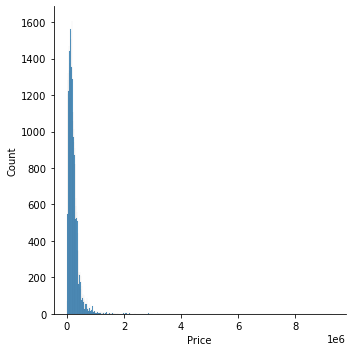

In [6]:
sns.displot(df_dummies.Price)

# Preparing the data for Pytorch

In [7]:
# Target variable:
output_col = [df_dummies.columns[0]]
output_col

['Price']

In [8]:
# Inputs
input_cols = df_dummies.columns[1::]
input_cols

Index(['Area (sqm.)', 'Year built', 'Type_Erillistalo', 'Type_Kerrostalo',
       'Type_Luhtitalo', 'Type_Mökki tai huvila', 'Type_Omakotitalo',
       'Type_Paritalo', 'Type_Puutalo-osake', 'Type_Rivitalo',
       ...
       'City_Ylitornio', 'City_Ylivieska', 'City_Ylöjärvi', 'City_Ypäjä',
       'City_Ähtäri', 'City_Äänekoski', 'Form of ownership_Asumisoikeusasunto',
       'Form of ownership_Muu', 'Form of ownership_Omistusasunto',
       'Form of ownership_Osaomistusasunto'],
      dtype='object', length=306)

In [9]:
def df_to_arrays(dataset):
    # Make a copy of the original dataset
    dataframe = dataset.copy(deep = True)

    # Extract input & outputs as numpy arrays
    inputs_array = dataframe[input_cols].to_numpy()
    targets_array = dataframe[output_col].to_numpy()
    return inputs_array, targets_array.reshape((len(dataset.index), 1))

In [10]:
inputs_array, targets_array = df_to_arrays(df_dummies)
inputs_array, targets_array

(array([[2.800e+01, 1.963e+03, 0.000e+00, ..., 0.000e+00, 1.000e+00,
         0.000e+00],
        [3.400e+01, 1.972e+03, 0.000e+00, ..., 0.000e+00, 1.000e+00,
         0.000e+00],
        [2.850e+01, 2.018e+03, 0.000e+00, ..., 0.000e+00, 1.000e+00,
         0.000e+00],
        ...,
        [2.450e+02, 1.991e+03, 1.000e+00, ..., 0.000e+00, 1.000e+00,
         0.000e+00],
        [8.000e+01, 1.986e+03, 0.000e+00, ..., 0.000e+00, 1.000e+00,
         0.000e+00],
        [7.850e+01, 2.000e+03, 0.000e+00, ..., 0.000e+00, 1.000e+00,
         0.000e+00]]),
 array([[169000.],
        [ 39000.],
        [139000.],
        ...,
        [268000.],
        [108500.],
        [489000.]]))

In [11]:
inputs = torch.Tensor(inputs_array)
targets = torch.Tensor(targets_array)

print(inputs)
print(targets)
inputs.shape, targets.shape

tensor([[2.8000e+01, 1.9630e+03, 0.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [3.4000e+01, 1.9720e+03, 0.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [2.8500e+01, 2.0180e+03, 0.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        ...,
        [2.4500e+02, 1.9910e+03, 1.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [8.0000e+01, 1.9860e+03, 0.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [7.8500e+01, 2.0000e+03, 0.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00]])
tensor([[169000.],
        [ 39000.],
        [139000.],
        ...,
        [268000.],
        [108500.],
        [489000.]])


(torch.Size([42582, 306]), torch.Size([42582, 1]))

In [12]:
num_rows = len(df_dummies.index)

dataset = TensorDataset(inputs, targets)

val_percent = 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_size, val_size

(34066, 8516)

### Dataloaders for training and validation

In [13]:
batch_size = 16

train_loader = DataLoader(train_ds, batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size)

In [14]:
input_size = len(input_cols)
output_size = len(output_col)

In [15]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)               
        
    def forward(self, xb):
        out = self.linear(xb)                        
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')  
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [16]:
model = LinearRegressionModel()

In [17]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [18]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 216254.859375}


In [19]:
epochs = 500
lr = 1e-7
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 199446.8750
Epoch [40], val_loss: 184242.1094
Epoch [60], val_loss: 171714.0938
Epoch [80], val_loss: 161385.6250
Epoch [100], val_loss: 152938.8125
Epoch [120], val_loss: 146095.6406
Epoch [140], val_loss: 140599.0625
Epoch [160], val_loss: 136187.2188
Epoch [180], val_loss: 132571.0781
Epoch [200], val_loss: 129630.4531
Epoch [220], val_loss: 127280.4531
Epoch [240], val_loss: 125425.7734
Epoch [260], val_loss: 124024.4375
Epoch [280], val_loss: 122904.9219
Epoch [300], val_loss: 122037.7500
Epoch [320], val_loss: 121346.6484
Epoch [340], val_loss: 120806.0547
Epoch [360], val_loss: 120400.0312
Epoch [380], val_loss: 120070.1719
Epoch [400], val_loss: 119802.0000
Epoch [420], val_loss: 119598.5859
Epoch [440], val_loss: 119439.7734
Epoch [460], val_loss: 119321.3203
Epoch [480], val_loss: 119227.1094
Epoch [500], val_loss: 119152.7188


In [25]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                
    prediction = predictions[0].detach()
    # print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)
    return (target.double() - prediction.double())

In [32]:
print(len(val_ds))

val_points = 100
error_perc_sum = 0
for i in range(val_points):
    input, target = val_ds[i]
    abs_err = predict_single(input, target, model)
    print('Absolute error:', abs_err[0].detach().numpy())
    error_perc_sum = error_perc_sum + (abs(abs_err[0].detach().numpy()) / target[0].detach().numpy())
    print('Relative error:', (abs(abs_err[0].detach().numpy()) / target[0].detach().numpy()), '\n\n')
    # error_perc_sum = error_perc_sum + (abs_err / target)

error_percentage = error_perc_sum / val_points
print(error_percentage * 100, '%')

8516
Target: tensor([179000.])
Prediction: tensor([163063.9375])
Absolute error: 15936.0625
Relative error: 0.08902828212290503 


Target: tensor([50000.])
Prediction: tensor([163289.7500])
Absolute error: -113289.75
Relative error: 2.265795 


Target: tensor([635364.])
Prediction: tensor([167659.1562])
Absolute error: 467704.84375
Relative error: 0.7361210955452308 


Target: tensor([110000.])
Prediction: tensor([161563.5469])
Absolute error: -51563.546875
Relative error: 0.46875951704545454 


Target: tensor([61000.])
Prediction: tensor([161010.0312])
Absolute error: -100010.03125
Relative error: 1.6395087090163933 


Target: tensor([285000.])
Prediction: tensor([167429.5938])
Absolute error: 117570.40625
Relative error: 0.4125277412280702 


Target: tensor([210000.])
Prediction: tensor([167457.0938])
Absolute error: 42542.90625
Relative error: 0.20258526785714287 


Target: tensor([369000.])
Prediction: tensor([167637.1875])
Absolute error: 201362.8125
Relative error: 0.545698678861

# Noticed problems and TODOs
The avg error is very high at roughly 140%. The problem seems to be that the network does not react to the inputs enough and the 
predictions seem to be in the same magnitude (around 160-170k€). Further adjustments need to be done for better results. 